# Eigen Portfolios

In [1]:
# Show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# YFinance
import yfinance as yf

# Pytickersymbols
import pytickersymbols
from pytickersymbols import PyTickerSymbols

# Common imports
import pandas as pd
import numpy as np
from datetime import datetime

# Numpy
from numpy.linalg import eig

# PLotly
import plotly.express as px
import kaleido

### Data cleansing (Adjusted Close)

We'll drop columns that have "too many" NaN values.

In [2]:
def clean_df_by_nan(df, pct_missing, fill_na):
    # Assert
    assert isinstance(df, pd.DataFrame)
    # Avoid overwritting original dataframe
    df = df.copy()
    # Compute the fraction of missing values per column
    missing_fractions = df.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > pct_missing].index))
    # Drop problematic columns
    if drop_list:
        df.drop(drop_list, axis=1, inplace=True)
    # Fill missing values with the last value avail. (forward-fill)
    if fill_na:
        df.fillna(method="ffill", inplace=True)
        df.dropna(axis=0, inplace=True)
    
    return df

### SP500

In [3]:
# Get US ticker symbols (SP500)
stock_data = PyTickerSymbols()
us_stocks = list(stock_data.get_stocks_by_index('S&P 500'))
us_ticker_symbols = [k["symbol"] for k in us_stocks]

# YFinance
us_hist_df = yf.download(tickers=us_ticker_symbols,
                         start="2000-01-01",
                         interval="1d")
us_hist_df.head(3)

[*********************100%***********************]  499 of 499 completed

3 Failed downloads:
- SSE: No data found for this date range, symbol may be delisted
- JEC: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted


Adj Close                                                         \
                    A AAL AAP      AAPL ABBV      ABC     ABMD       ABT ACN   
Date                                                                           
1999-12-31        NaN NaN NaN       NaN  NaN      NaN      NaN       NaN NaN   
2000-01-03  44.404324 NaN NaN  0.859423  NaN  3.04689  18.2500  9.454567 NaN   
2000-01-04  41.012321 NaN NaN  0.786965  NaN  2.83887  17.8125  9.184438 NaN   

                       ...     Volume                                       \
                 ADBE  ...        XEL       XLNX         XOM      XRAY XYL   
Date                   ...                                                   
1999-12-31        NaN  ...        NaN        NaN         NaN       NaN NaN   
2000-01-03  16.274673  ...  2738600.0  7698700.0  13458200.0  582200.0 NaN   
2000-01-04  14.909401  ...   425200.0  7399600.0  14510800.0  317600.0 NaN   

                                                     
                  YUM ZBH       ZBRA       ZION ZTS  
Date                                                 
1999-12-31        NaN NaN        NaN        NaN NaN  
2000-01-03  3033400.0 NaN  1055700.0  1199600.0 NaN  
2000-01-04  3315000.0 NaN   522400.0   816100.0 NaN  

[3 rows x 2994 columns]

#### Removing NaNs

In [4]:
# Removing NaN values
us_adjClose = clean_df_by_nan(df=us_hist_df["Adj Close"], pct_missing=0.1, fill_na=True)
us_adjClose.shape

(4987, 387)

#### Log Returns (stationarity)

In [5]:
# Individual securities
us_log_rets = np.log(us_adjClose) - np.log(us_adjClose.shift(1))
us_log_rets = us_log_rets.dropna(axis=0)
us_log_rets.shape 

(4986, 387)

#### AAPL Log Returns

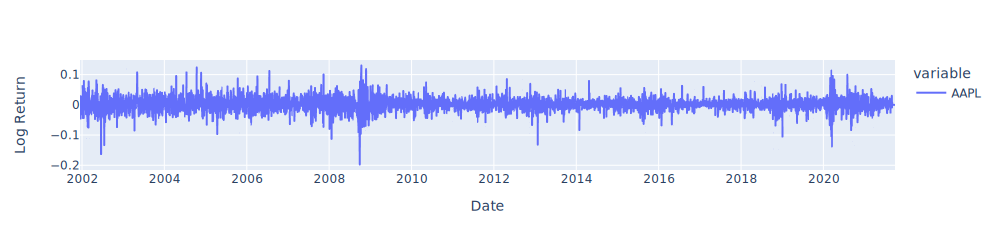

In [6]:
aapl_fig = px.line(us_log_rets["AAPL"],
                   labels={"value": "Log Return"},
                   width=1000,
                   height=250)
aapl_fig.show("svg")

#### Correlation matrix (Adjusted Close)

(387, 387)

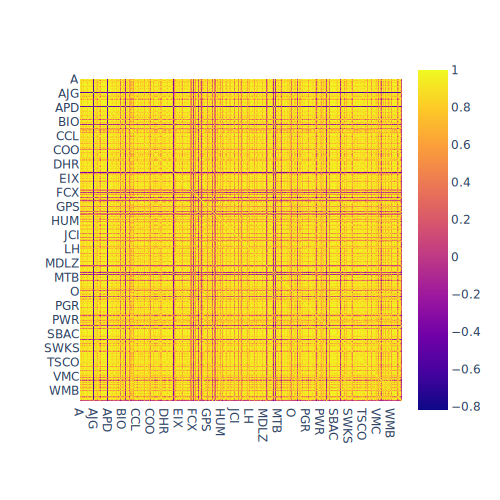

In [7]:
us_corr_adjClose = us_adjClose.corr()
corr_fig1 = px.imshow(us_corr_adjClose, width=500)
us_corr_adjClose.shape
corr_fig1.show("svg")

#### Correlation matrix (Log Returns)

(387, 387)

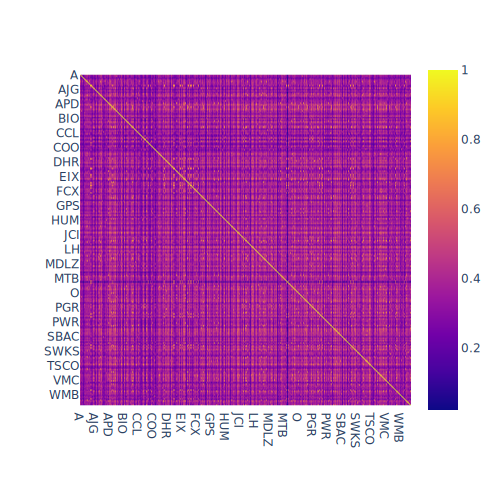

In [8]:
us_corr_log_rets = us_log_rets.corr()
corr_fig2 = px.imshow(us_corr_log_rets, width=500)
us_corr_log_rets.shape
corr_fig2.show("svg")

### Data preprocessing

In [9]:
# Standardizing
mu, sigma = us_log_rets.mean(), us_log_rets.std()
us_log_rets_rescaled = (us_log_rets.sub(mu, axis=1)).div(sigma, axis=1)

# Train-test split
cutoff = 0.75
n = len(us_log_rets_rescaled)
X_train_raw, X_test_raw = us_log_rets[:int(n*cutoff)], us_log_rets[int(n*cutoff):]
X_train_rescaled , X_test_rescaled = us_log_rets_rescaled[:int(n*cutoff)], us_log_rets_rescaled[int(n*cutoff):]

X_train_raw.shape
X_test_raw.shape

X_train_rescaled.shape
X_test_rescaled.shape

(3739, 387)

(1247, 387)

(3739, 387)

(1247, 387)

### Principal Component Analysis

**Objective**: Project the data onto a lower dimensional *linear* space such that the *variance* of the projected data is *maximized*. Equivalently, it is the linear projection that *minimizes* the average projection cost (mean squared distance between data points and their projections).

#### Covariance matrix of asset returns

In [10]:
X_train_cov = X_train_rescaled.cov()
X_train_cov.shape

(387, 387)

### Eigenvalues and Eigenvectors

***Python Programming and Numerical Methods: A Guide for Engineers and Scientists by Qingkai Kong, Timmy Siauw, and Alexandre M.Bayen (Chapter 15)***

[We learned from the previous chapter that] matrix $A$ applied to a column vector $x$, that is $Ax$ is a *linear transformation* of $x$. There is a special *transform* in the followign form:


$$Ax = \lambda{}x$$

$A$ is an $n \times{} n$ [square] matrix, $x$ is an $n \times{} 1$ column vector ($x \ne 0$), and $\lambda{}$ is a scalar. Any $\lambda{}$ that satisfies the above equation is known as an **eigenvalue** of the matrix $A$, while the associated vector $x$ is called the **eigenvector** corresponding to $\lambda{}$.

The calculation of eigenvalues and eigenvectors in Python is fairly easy. The main built-in function in Python to solve the eigenvalue/eigenvector problem for a *square* array is the `eig` function in `numpy.linalg`.


For a covariance or correlation matrix, the *sum* of its eigenvalues equals the trace of the matrix, that is, the sum of the variances of the $n_{y}$ variables for a covariance matrix, and $n_{y}$ for a correlation matrix. The principal components are sorted by descending order of their variances, which are equal to the associated eigenvalues.

- https://v8doc.sas.com/sashtml/insight/chap40/sect3.htm

In [11]:
eigenvalues, eigenvectors = eig(X_train_cov)
print(f"Sum of variances (from original data): {X_train_cov.to_numpy().diagonal().sum():.4f}")
print(f"Sum of eigenvalues: {eigenvalues.sum():.4f}")

Sum of variances (from original data): 390.6078
Sum of eigenvalues: 390.6078


#### Explained variance ratios

In [12]:
exp_var_ratios = eigenvalues / eigenvalues.sum()
exp_var_ratios.shape
exp_var_ratios.sum()

(387,)

0.9999999999999996

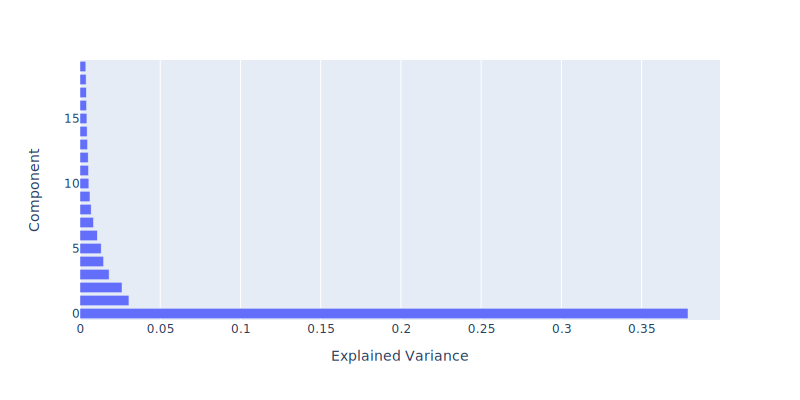

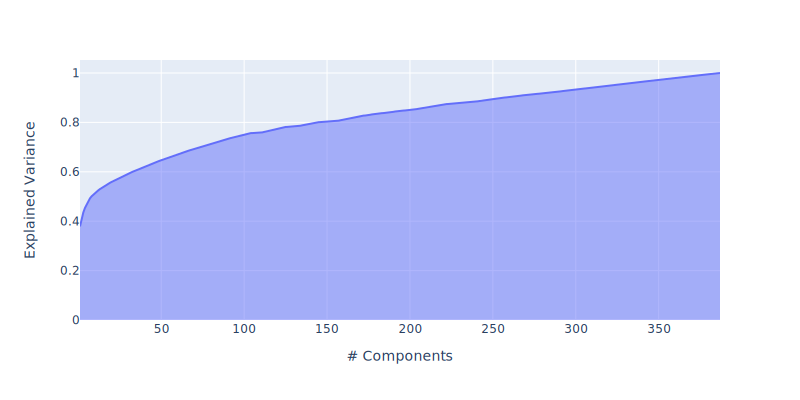

In [21]:
# Explained variace ratio by Top Factors
exp_var_ratios_fig = px.bar(x=exp_var_ratios[:20],
                            labels={"x": "Explained Variance", "y": "Component"},
                            height=400,
                            width=800)

# Explained cumulative variance
exp_var_cumul = np.cumsum(exp_var_ratios)
exp_var_cumul_fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
                            y=exp_var_cumul,
                            labels={"x": "# Components", "y": "Explained Variance"},
                            height=400,
                            width=800)

exp_var_ratios_fig.show("svg")
exp_var_cumul_fig.show("svg")

### Eigen Portfolios

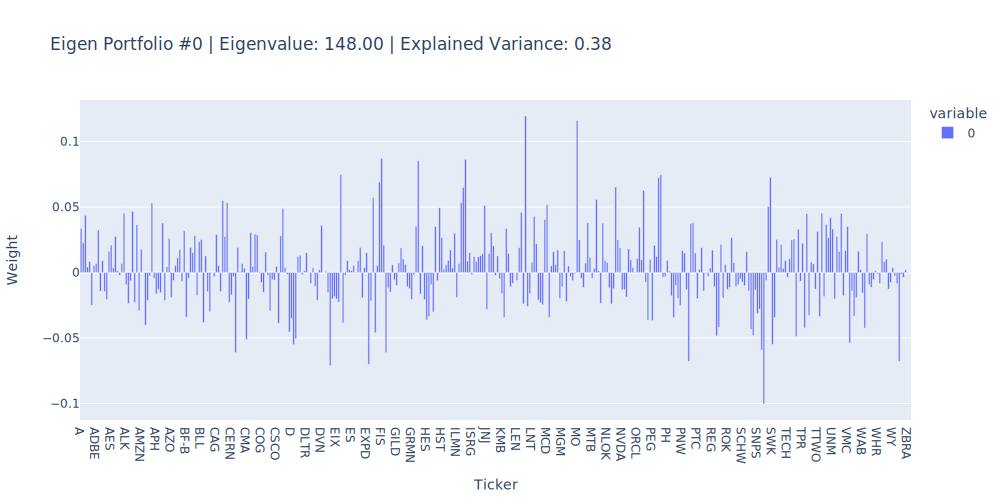

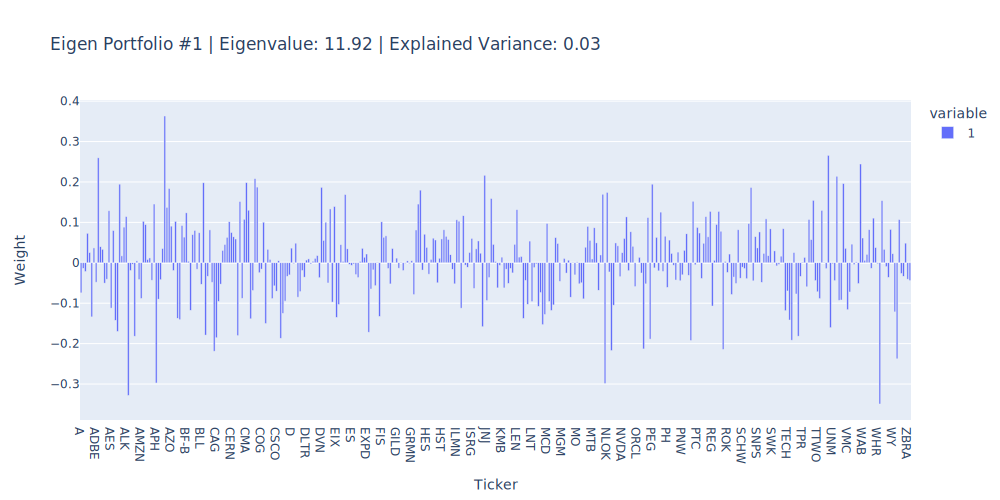

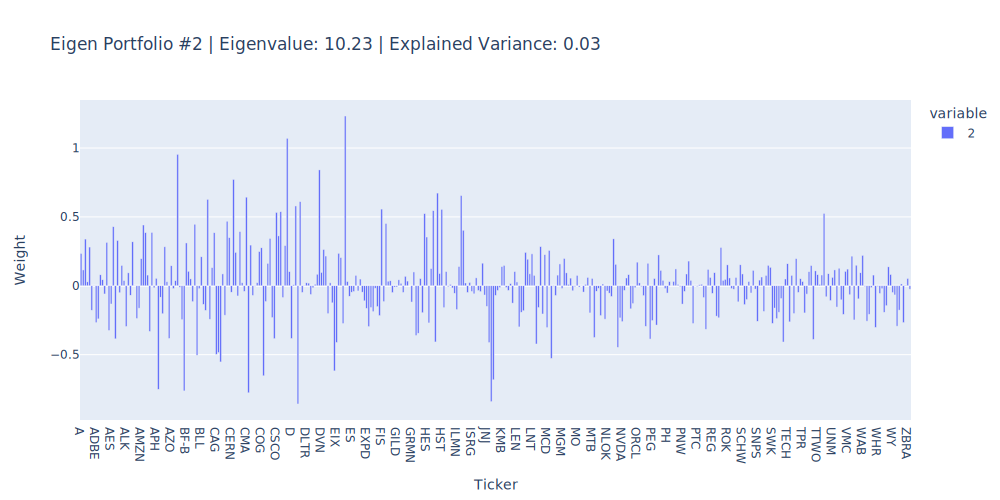

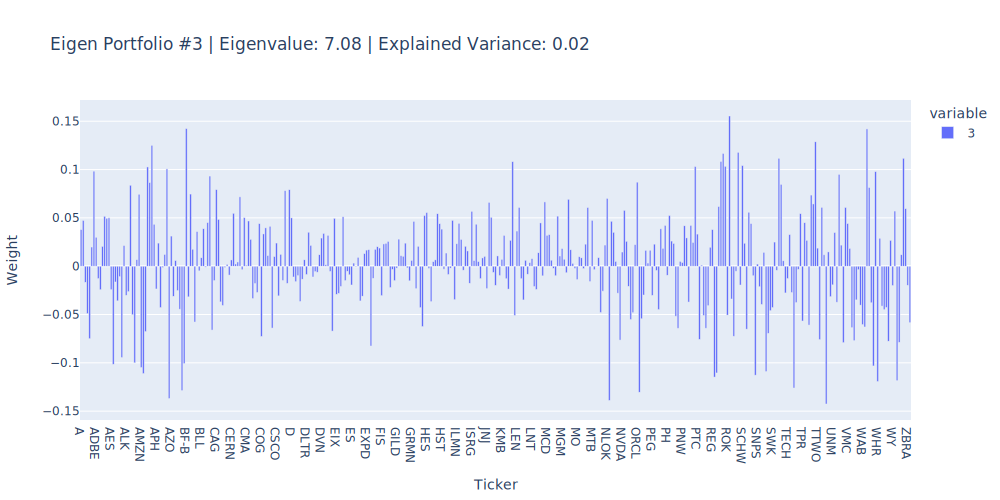

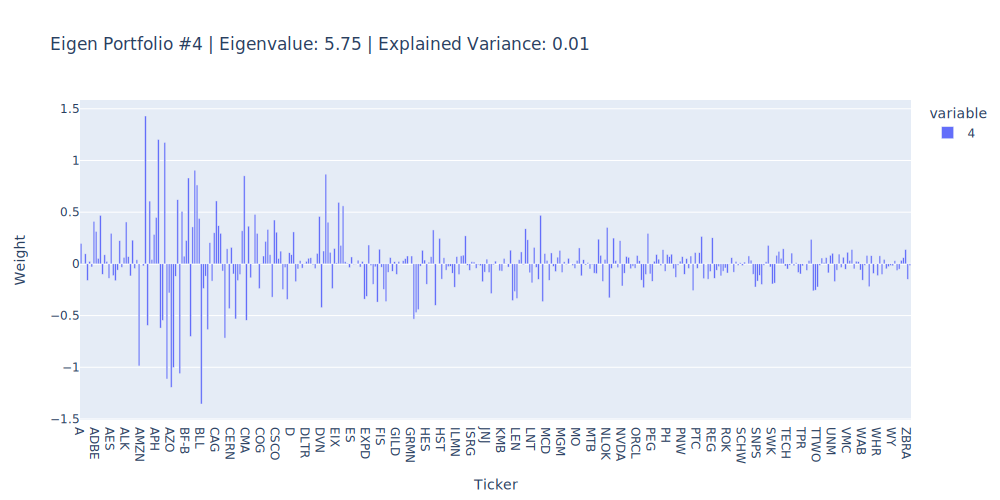

In [22]:
eigenPortfolios = list(map(lambda x: x / x.sum(), eigenvectors))
eigenPortfolios_df = pd.DataFrame(eigenPortfolios, columns=X_train_raw.columns)

for i in range(5):
    
    fig_i = px.bar(eigenPortfolios_df.iloc[i].to_frame(),
                   title=f"Eigen Portfolio #{i} | Eigenvalue: {eigenvalues[i]:.2f} | Explained Variance: {exp_var_ratios[i]:.2f}",
                   labels={"index":"Ticker", "value": "Weight"},
                   width=1000,
                   height=500)
    
    fig_i.show("svg")

### Finding the best eigen portfolio

In [15]:
def get_sharpe_ratio(x):
    assert len(x.shape) == 1
    ann_ret = x.mean() * 252
    ann_std = x.std() * np.sqrt(252)
    sr = ann_ret / ann_std
    return ann_ret, ann_std, sr

my_eigenports = {"Eigen Portfolio #" : [],
                 "Weights" : [],
                 "Return" : [],
                 "Volatility": [],
                 "Sharpe Ratio" : []}

# Compute Sharpe Ratio for every eigen portfolio
for i in range(len(eigenPortfolios_df)):
    eigenPort_i = eigenPortfolios_df.iloc[i].to_numpy()
    rets_i = np.dot(X_train_raw, eigenPort_i)
    ret, vol, sr = get_sharpe_ratio(rets_i)
    my_eigenports["Eigen Portfolio #"].append(str(i))          
    my_eigenports["Weights"].append(eigenPort_i)
    my_eigenports["Return"].append(ret)
    my_eigenports["Volatility"].append(vol)
    my_eigenports["Sharpe Ratio"].append(sr)

### Sharpe ratios of all eigen portfolios

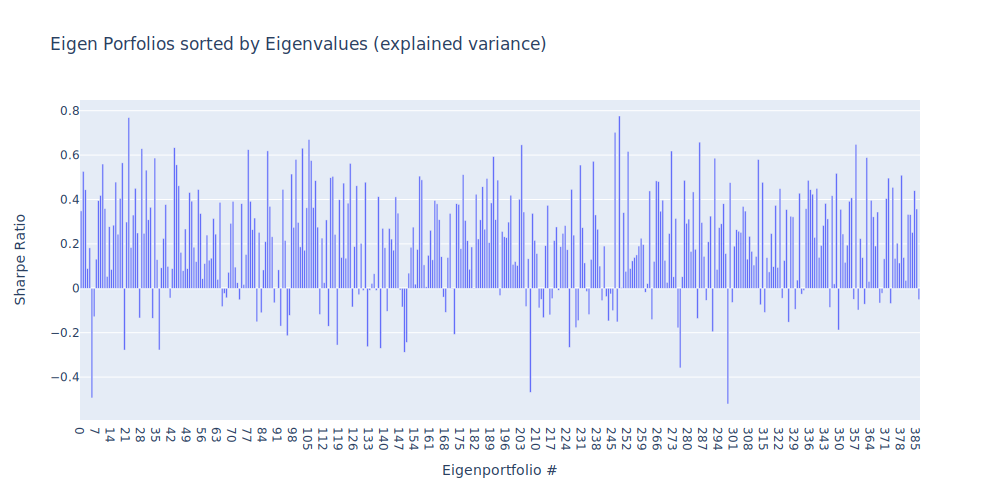

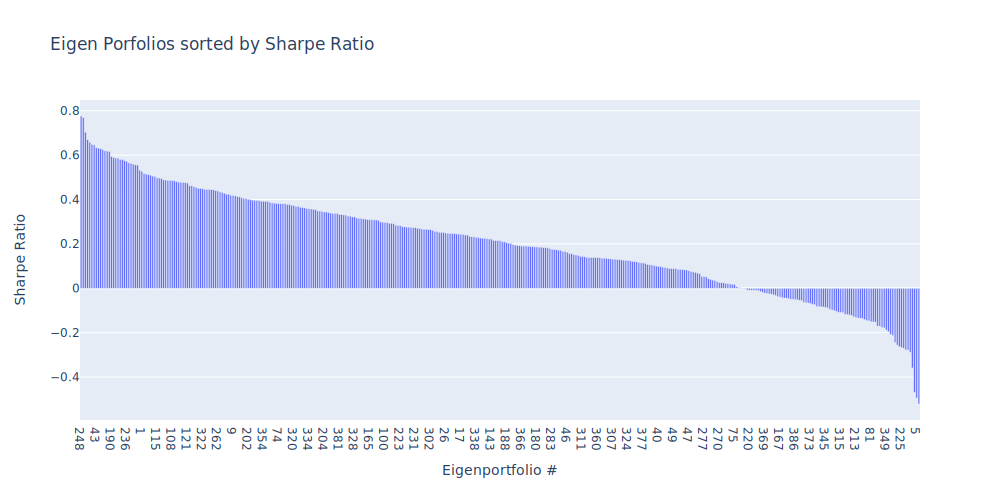

In [16]:
eigenports_sr_df = pd.DataFrame(my_eigenports["Sharpe Ratio"], columns=["Sharpe Ratio"])
eigenports_sr_sorted_df = eigenports_sr_df.sort_values(by="Sharpe Ratio", ascending=False)

eigenports_sr_fig1 = px.bar(x=list(map(str, eigenports_sr_df.index.to_numpy().squeeze())),
                            y=eigenports_sr_df.to_numpy().squeeze(),
                            labels = {"x": "Eigenportfolio #", "y": "Sharpe Ratio"},
                            title="Eigen Porfolios sorted by Eigenvalues (explained variance)",
                            width=1000,
                            height=500)

eigenports_sr_fig2 = px.bar(x=list(map(str, eigenports_sr_sorted_df.index.to_numpy().squeeze())),
                            y=eigenports_sr_sorted_df.to_numpy().squeeze(),
                            labels={"x": "Eigenportfolio #", "y": "Sharpe Ratio"},
                            title="Eigen Porfolios sorted by Sharpe Ratio",
                            width=1000,
                            height=500)

eigenports_sr_fig1.show("svg")
eigenports_sr_fig2.show("svg")

### Backtesting eigen portfolios

In [17]:
# Top eigen portfolios
n_eigen_ports = 5
top_eigen_ports = eigenports_sr_sorted_df.index[:n_eigen_ports]
top_eigen_weights = [my_eigenports["Weights"][i] for i in top_eigen_ports]

# Returns
top_eigen_rets = np.array(list(map(lambda n: np.dot(X_test_raw, n), top_eigen_weights)))
top_eigen_cumsum = np.array(list(map(lambda n: 1. + n.cumsum(), top_eigen_rets)))
top_eigen_df = pd.DataFrame(top_eigen_cumsum.T, 
                            columns=list(map(str, top_eigen_ports)), 
                            index=X_test_raw.index)

# Equal-weighted eigen portfolio
ew_eigen_rets = (top_eigen_rets.T * (1./top_eigen_rets.T.shape[1])).sum(axis=1)
ew_eigen_cumsum = 1. + ew_eigen_rets.cumsum()
ew_eigen_df = pd.DataFrame(ew_eigen_cumsum,
                           columns=["EW-Eigen"],
                           index=X_test_raw.index)

# Equal-weighted SP500
ew_sp_rets = (X_test_raw * (1./X_test_raw.shape[1])).sum(axis=1)
ew_sp_cumsum = 1. + ew_sp_rets.cumsum()
ew_sp_df = pd.DataFrame(ew_sp_cumsum,
                        columns=["EW-SP500"],
                        index=X_test_raw.index)

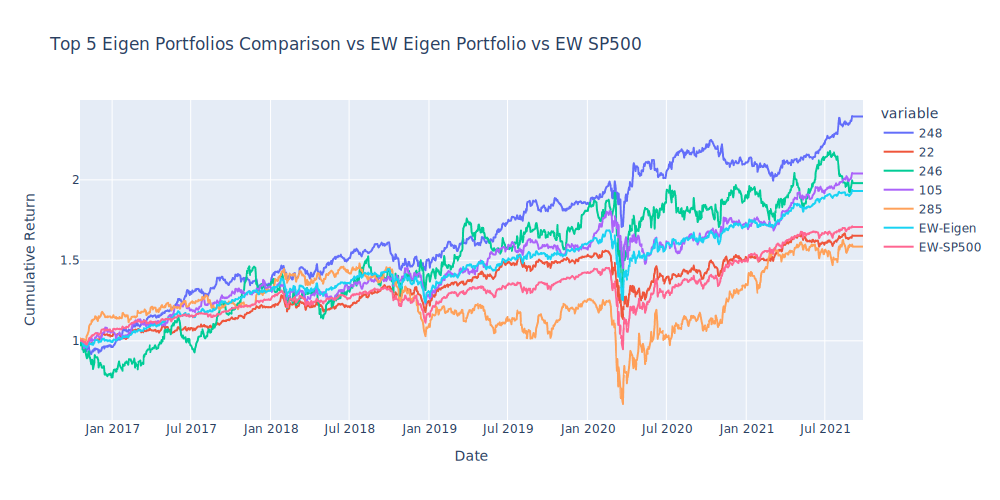

In [23]:
all_eigein_ports_df = (top_eigen_df.join(ew_eigen_df)).join(ew_sp_df)
all_eigein_ports_fig = px.line(all_eigein_ports_df,
                        labels={"value" : "Cumulative Return"},
                        title=f"Top {top_eigen_df.shape[1]} Eigen Portfolios Comparison vs EW Eigen Portfolio vs EW SP500",
                        width=1000,
                        height=500)

all_eigein_ports_fig.show("svg")